# Install and import dependencies

In [ ]:
!pip install wikipedia-api
!pip install textacy
!pip install dateparser
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install datasets
!pip install spacy-transformers

In [2]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re   

## for nlp
import spacy  #3.5.0
import spacy_transformers
from spacy import displacy
import textacy  #0.12.0

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)
import pygraphviz

## for timeline
import dateparser #1.1.7

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Download SpaCy's pretrained transformer model

In [ ]:
!python -m spacy download en_core_web_trf

# Load Wikipedia text data

In [5]:
wiki = wikipediaapi.Wikipedia('en')

In [6]:
page_history = wiki.page("Iraq War")
txt_history = page_history.text[:page_history.text.find("See also")]
txt_history[0:500] + " ..."

'The Iraq War was a protracted armed conflict in Iraq from 2003 to 2011 that began with the invasion of Iraq by the United States-led coalition that overthrew the Iraqi government of Saddam Hussein. The conflict continued for much of the next decade as an insurgency emerged to oppose the coalition forces and the post-invasion Iraqi government. US troops were officially withdrawn in 2011. The United States became re-involved in 2014 at the head of a new coalition, and the insurgency and many dimen ...'

# Application

### 1.   Load the model and perform NLP processing



The function analyse_article loads SpaCy's pretrained transformer model and process the data to produce a Doc object containing all NLP tags (parts of speech, dependency, named entity) for each token

![image.png](https://spacy.io/images/pipeline.svg)

In [8]:
def analyse_article(nlp_model:str, article:str, limit:str):
    page = wiki.page(article)
    txt = page.text[:page.text.find(limit)]
    txt[0:500] + " ..."
    nlp = spacy.load(nlp_model)
    doc = nlp(txt)
    return doc

In [9]:
doc_history_pretrained = analyse_article("en_core_web_trf", "Iraq War", "See also")

In [10]:
# perform sentence segmentation to obtain a list of sentences
lst_docs_history_pretrained = [sent for sent in doc_history_pretrained.sents]
print("tot sentences:", len(lst_docs_history_pretrained))

tot sentences: 591


#### Example of tokenisation, POS tagging, dependency parsing and NER

In [11]:
# take a sentence
i = 0
lst_docs_history_pretrained[i]

The Iraq War was a protracted armed conflict in Iraq from 2003 to 2011 that began with the invasion of Iraq by the United States-led coalition that overthrew the Iraqi government of Saddam Hussein.

In [12]:
for token in lst_docs_history_pretrained[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

The --> pos: DET | dep: det 
Iraq --> pos: PROPN | dep: compound 
War --> pos: PROPN | dep: nsubj 
was --> pos: AUX | dep: ROOT 
a --> pos: DET | dep: det 
protracted --> pos: VERB | dep: amod 
armed --> pos: ADJ | dep: amod 
conflict --> pos: NOUN | dep: attr 
in --> pos: ADP | dep: prep 
Iraq --> pos: PROPN | dep: pobj 
from --> pos: ADP | dep: prep 
2003 --> pos: NUM | dep: pobj 
to --> pos: ADP | dep: prep 
2011 --> pos: NUM | dep: pobj 
that --> pos: PRON | dep: nsubj 
began --> pos: VERB | dep: relcl 
with --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
invasion --> pos: NOUN | dep: pobj 
of --> pos: ADP | dep: prep 
Iraq --> pos: PROPN | dep: pobj 
by --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
United --> pos: PROPN | dep: compound 
States --> pos: PROPN | dep: npadvmod 
- --> pos: PUNCT | dep: punct 
led --> pos: VERB | dep: amod 
coalition --> pos: NOUN | dep: pobj 
that --> pos: PRON | dep: nsubj 
overthrew --> pos: VERB | dep: relcl 
the --> pos: DET | dep:

In [ ]:
displacy.render(lst_docs_history_pretrained[i], style="dep", jupyter=True, options={"distance":100})

In [13]:
for tag in lst_docs_history_pretrained[i].ents:
    print(tag.text, f"({tag.label_})") 

The Iraq War (EVENT)
Iraq (GPE)
Iraq (GPE)
United States (GPE)
Iraqi (NORP)
Saddam Hussein (PERSON)


In [ ]:
displacy.render(lst_docs_history_pretrained[i], style="ent", jupyter=True)

### 2.   Entity and Relation Extraction



Function to extract the entities in a sentence

In [14]:
def extract_entity(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
        
        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " " + tok.text
        
        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier + " " + prefix + " " + tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier + " " + prefix + " " + tok.text

Function to extract the tokens that represent a relation by checking the linked tokens' dependency tag (DEP) and POS tag:
*   DEP is ROOT: token is a verb (compulsory)
*   DEP is prep: the verb has a prepositional modifier (optional)
*   DEP is agent: the verb has an agent (optional)
*   POS tag is ADJ: an adjective token (optional)




In [15]:
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

Two methods to extract entities and relations, and return a panda dataframe

In [16]:
# using textacy's subject, object, verb triple extraction
# https://textacy.readthedocs.io/en/latest/api_reference/extract.html#textacy.extract.triples.subject_verb_object_triples
def entities_relation_extraction(lst_docs: list):
    
    dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

    for n,sentence in enumerate(lst_docs):
        lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
        for sent in lst_generators:
            subj = "_".join(map(str, sent.subject))
            obj  = "_".join(map(str, sent.object)).replace('$', '')
            relation = "_".join(map(str, sent.verb))
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic["entity"].append(subj)
            dic["object"].append(obj)
            dic["relation"].append(relation)

    ## create dataframe
    dtf = pd.DataFrame(dic)
    return dtf

# using textacy's semistructured statements extraction (entity, cue, fragment triples)
# https://textacy.readthedocs.io/en/latest/api_reference/extract.html#textacy.extract.triples.semistructured_statements
def entities_relation_extraction2(doc, subject:str):
    dic = {"entity":[], "relation":[], "object":[]}
    id = 0

    for cue in ["be", "have", "write", "talk", "talk about"]:
        statements = textacy.extract.semistructured_statements(doc, entity=subject, cue=cue)  
        for statement in statements:
            entity, cue, fact = statement

            dic["entity"].append("_".join(map(str, entity)))
            dic["relation"].append("_".join(map(str, cue)))
            dic["object"].append("_".join(map(str, fact)))
            
    ## create dataframe
    dtf = pd.DataFrame(dic)
    return dtf

Extract entities and relations example

In [17]:
iraq_dtf1 = entities_relation_extraction(lst_docs_history_pretrained)
print(iraq_dtf1.shape)
iraq_dtf1.head(30)

(453, 5)


,id,text,entity,relation,object
0,0,The Iraq War was a protracted armed conflict i...,that,overthrew,government
1,5,"\nIn October 2002, Congress granted Bush the p...",Congress,granted,power
2,6,"The Iraq War began on 20 March 2003, when the ...",US,launched,bombing_campaign
3,11,This build-up gave greater control to Iraq's g...,build_up,gave,control
4,14,United States based most of its rationale for ...,United_States,based,most
5,15,"Additionally, some US officials accused Saddam...",US_officials,accused,Saddam
6,18,Bush administration officials made numerous cl...,administration_officials,made,claims
7,19,The rationale for war faced heavy criticism bo...,rationale,faced,criticism
8,20,"Kofi Annan, then the Secretary-General of the ...",Kofi_Annan,called,invasion
9,20,"Kofi Annan, then the Secretary-General of the ...",it,violated,UN_Charter


In [18]:
iraq_dtf2 = entities_relation_extraction2(doc_history_pretrained, "Iraq")
iraq_dtf2

,entity,relation,object
0,Iraq,had,a_weapons_of_mass_destruction_(_WMD_)_program
1,Iraq,did_not_have,weapons_of_mass_destruction
2,Iraq,had,no_nuclear_weapons
3,Iraq,had,biological_weapons
4,Iraq,had,ties_to_al_-_Qaeda
5,Iraq,did_not_have,a_viable_WMD_program
6,Iraq,to_have,a_civilian_nuclear_program


Combine results from the two methods

In [19]:
frames = [iraq_dtf1, iraq_dtf2]
iraq_dtf = pd.concat(frames)

Optional: attribute (such as dates) extraction using NER

In [20]:
def attribute_extraction(attribute: str, lst_docs: list):
    dic = {"id":[], "text":[], attribute:[]}

    for n,sentence in enumerate(lst_docs):
        lst = list(textacy.extract.entities(sentence, include_types={attribute}))
        if len(lst) > 0:
            for attr in lst:
                dic["id"].append(n)
                dic["text"].append(sentence.text)
                dic[attribute].append(str(attr))
        else:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(np.nan)

    dtf_att = pd.DataFrame(dic)
    dtf_att = dtf_att[~dtf_att[attribute].isna()]
    return dtf_att

In [21]:
## example
iraq_dtf_att = attribute_extraction("DATE", lst_docs_history_pretrained)
iraq_dtf_att#[iraq_dtf_att["id"]==6]

,id,text,DATE
1,1,The conflict continued for much of the next de...,next decade
2,2,US troops were officially withdrawn in 2011.,2011
3,3,The United States became re-involved in 2014 a...,2014
4,4,The invasion occurred as part of the George W....,September 11
5,5,"\nIn October 2002, Congress granted Bush the p...",October 2002
...,...,...,...
637,582,"In 2017, US-backed Kurdish forces captured Raq...",2017
638,583,The Iraqi government declared victory against ...,December 2017
639,584,"By 2018, violence in Iraq was at its lowest le...",2018
640,584,"By 2018, violence in Iraq was at its lowest le...",ten years


### 3.   Create Knowledge Graph and Timeline



### Knowledge Graph

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


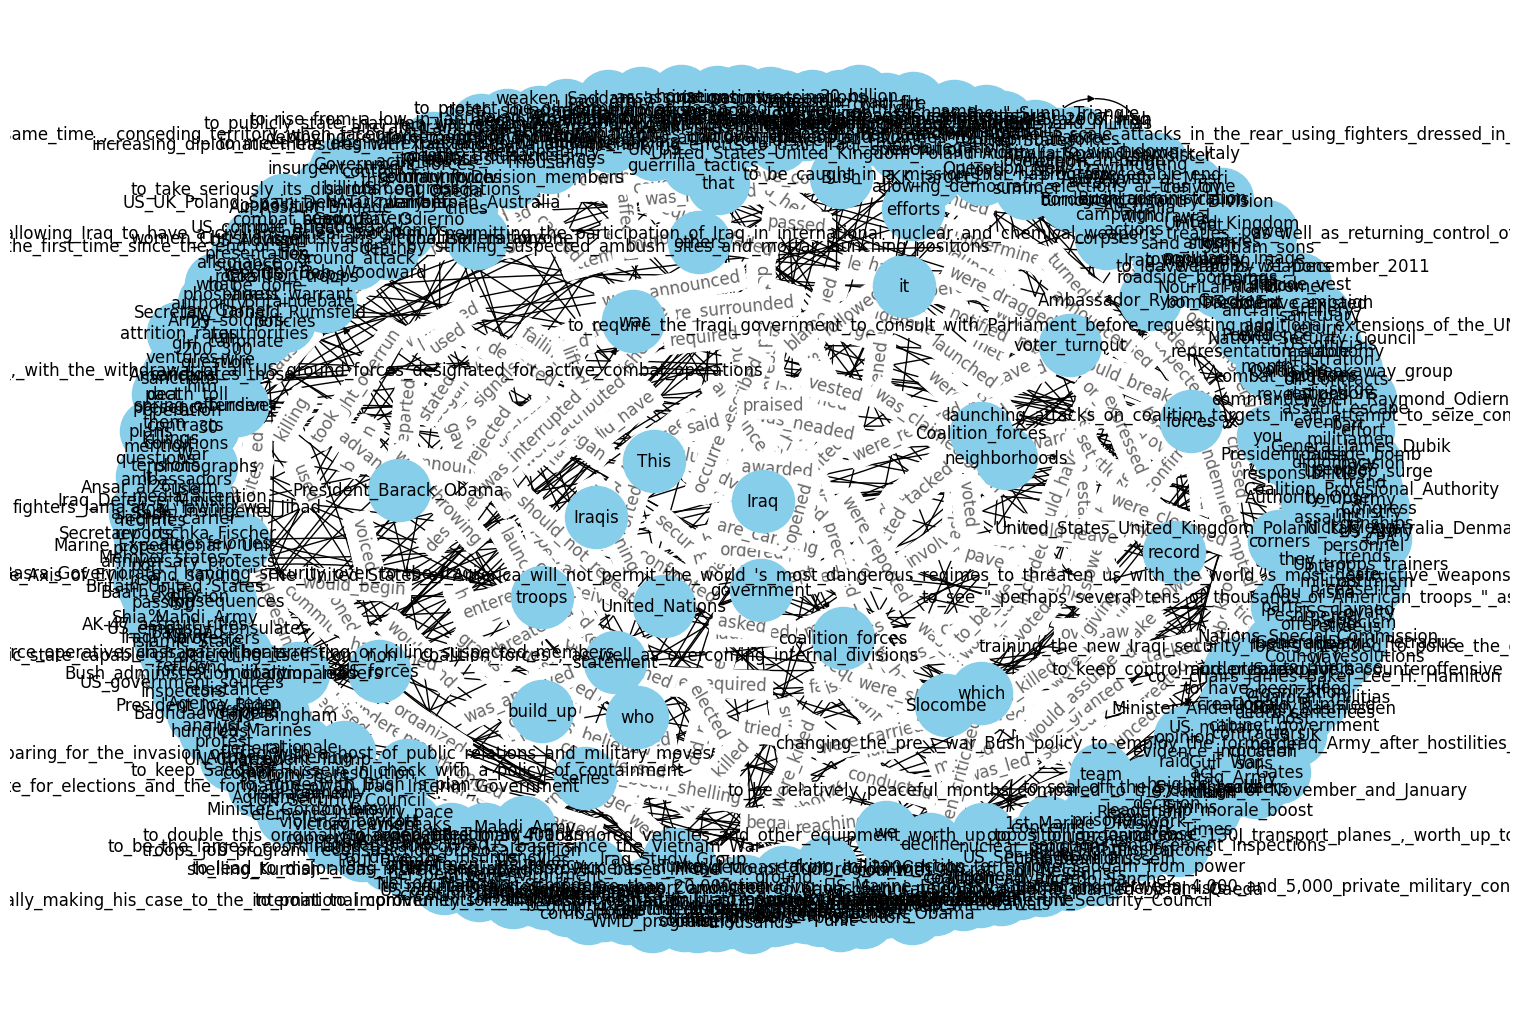

In [ ]:
## create full graph
G = nx.from_pandas_edgelist(iraq_dtf1, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()


Create graph networks with Python's NetworkX library

In [26]:
def create_knowledge_graph(dtf):
    G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


    ## plot
    plt.figure(figsize=(15,10))

    pos = nx.spring_layout(G, k=1)
    node_color = ["red" if node==f else "skyblue" for node in G.nodes]
    edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

    nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
            edge_color=edge_color, cmap=plt.cm.Dark2, 
            node_size=2000, connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                            edge_labels=nx.get_edge_attributes(G,'relation'),
                            font_size=12, font_color='black', alpha=0.6)
    plt.show()

The full graph is too large, so we will filter to get the entities that appear most frequently. This can also be done with the relation or object by replacing "entity" with "relation" or "object"

In [22]:
iraq_dtf["entity"].value_counts().head(10)

Iraq             25
that             18
which            16
government       11
it               11
who              10
US_forces         9
forces            8
Bush              8
United_States     7
Name: entity, dtype: int64

"Iraq" is the entity that appears most frequently, so we use it

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


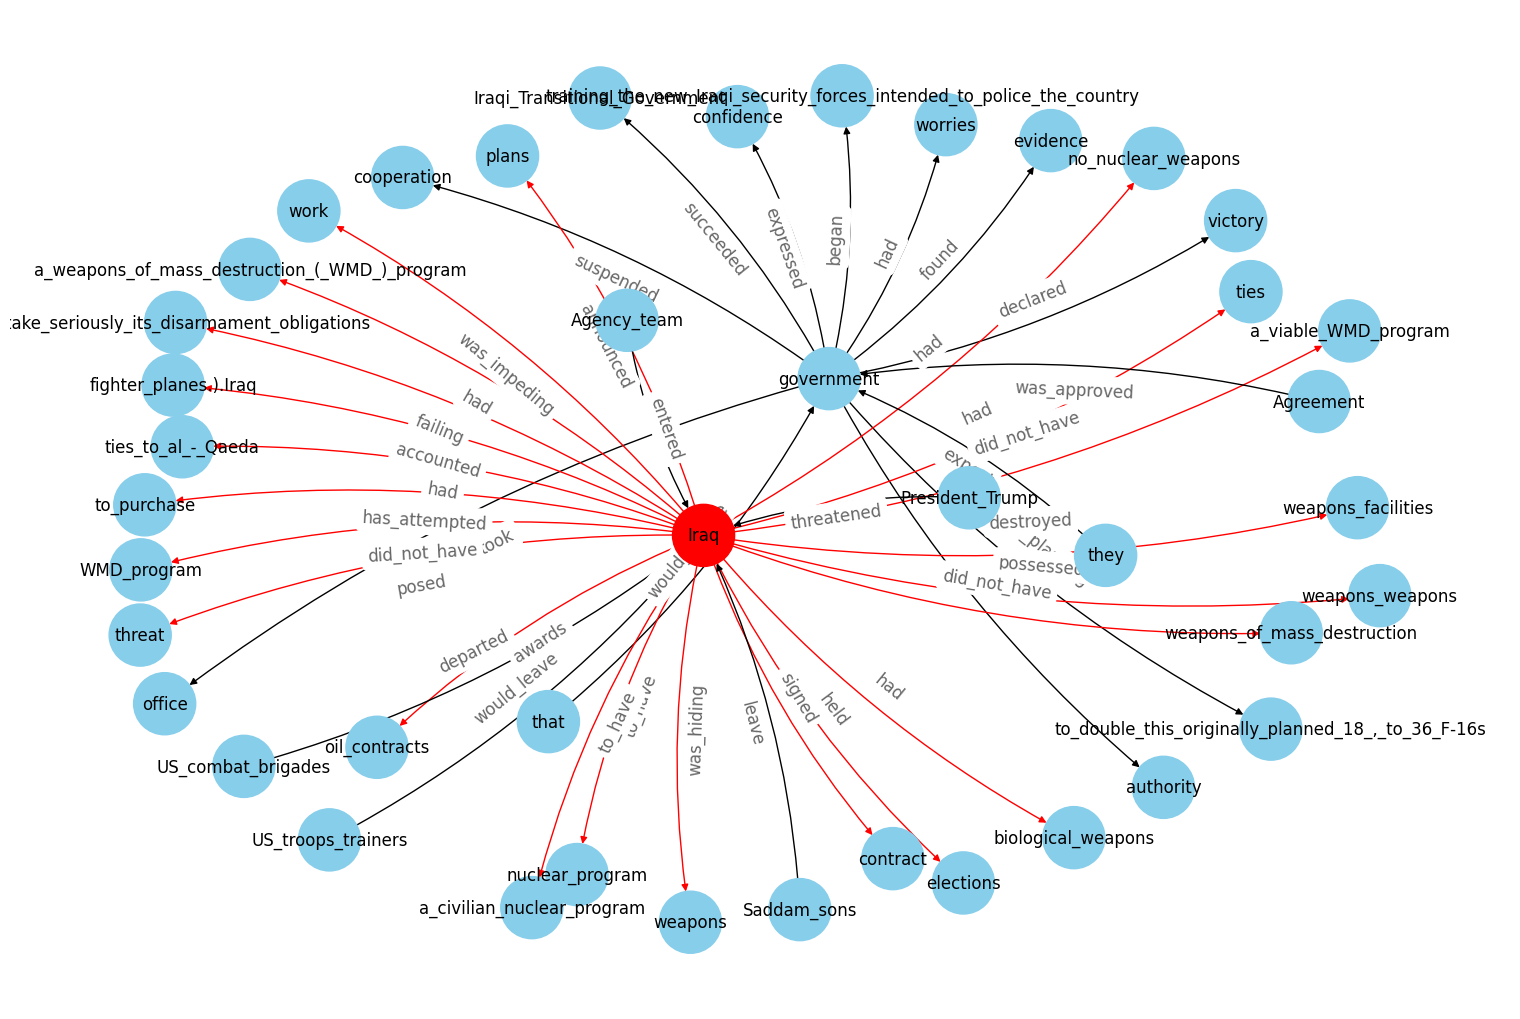

In [27]:
## filter
f = "Iraq"
tmp = iraq_dtf[((iraq_dtf["entity"]==f) | (iraq_dtf["object"]==f) | (iraq_dtf["object"]=="government") | (iraq_dtf["entity"]=="government")) & (iraq_dtf["id"]!=420)]


## create smallr graph focused on the filter entity
create_knowledge_graph(tmp)

Knowledge graphs can also be drawn in 3D

In [23]:
from mpl_toolkits.mplot3d import Axes3D

def create_3d_knowledge_graph(dtf):
    G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection="3d")
    pos = nx.spring_layout(G, k=2.5, dim=3)

    nodes = np.array([pos[v] for v in sorted(G) if v!=f])
    center_node = np.array([pos[v] for v in sorted(G) if v==f])

    edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v!=f])
    center_edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v==f])

    ax.scatter(*nodes.T, s=200, ec="w", c="skyblue", alpha=0.5)
    ax.scatter(*center_node.T, s=200, c="red", alpha=0.5)

    for link in edges:
        ax.plot(*link.T, color="grey", lw=0.5)
    for link in center_edges:
        ax.plot(*link.T, color="red", lw=0.5)
        
    for v in sorted(G):
        ax.text(*pos[v].T, s=v)
    for u,v in G.edges():
        attr = nx.get_edge_attributes(G, "relation")[(u,v)]
        ax.text(*((pos[u]+pos[v])/2).T, s=attr)

    ax.set(xlabel=None, ylabel=None, zlabel=None, 
        xticklabels=[], yticklabels=[], zticklabels=[])
    ax.grid(False)
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    plt.show()


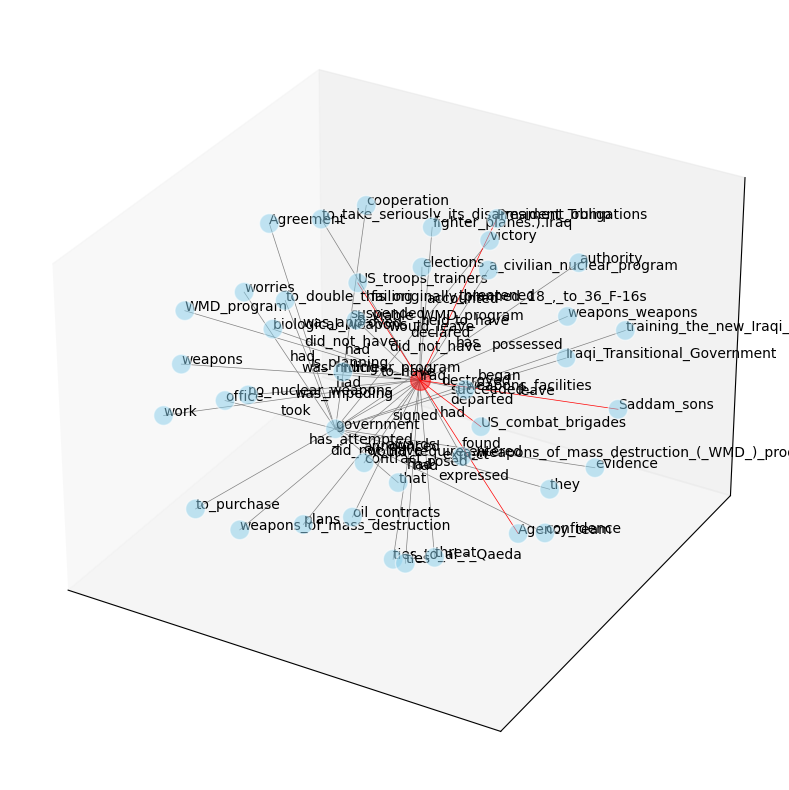

In [28]:
create_3d_knowledge_graph(tmp)

### Timeline
Using the dates extracted with NER, we can also create a timeline of events

In [ ]:
def utils_parsetime(txt):
    #x = re.match(r'.*([1-3][0-9]{3})', txt) #<--check if there is a year
    #if x is not None:

    dt = dateparser.parse(txt)

    return dt

In [ ]:
iraq_dtf_att["dt"] = iraq_dtf_att["DATE"].apply(lambda x: utils_parsetime(x))

## example
iraq_dtf_att[iraq_dtf_att["id"]==1]

,id,text,DATE,dt
1,1,The conflict continued for much of the next de...,next decade,2033-05-15 03:09:13.878522


In [ ]:
tmp = iraq_dtf.copy()
tmp["y"] = tmp["entity"]+" "+tmp["relation"]+" "+tmp["object"]

iraq_dtf_att = iraq_dtf_att.merge(tmp[["id","y"]], how="left", on="id")
iraq_dtf_att = iraq_dtf_att[~iraq_dtf_att["y"].isna()].sort_values("dt", 
                 ascending=True).drop_duplicates("y", keep='first')
iraq_dtf_att.head()

,id,text,DATE,dt,y
25,37,The international community condemned the inva...,1991,1991-05-15 00:00:00,community condemned invasion
26,37,The international community condemned the inva...,1991,1991-05-15 00:00:00,coalition launched Gulf_War
33,46,Iraqi officials harassed the inspectors and ob...,August 1998,1998-08-15 00:00:00,government suspended cooperation
32,46,Iraqi officials harassed the inspectors and ob...,August 1998,1998-08-15 00:00:00,officials obstructed work
31,46,Iraqi officials harassed the inspectors and ob...,August 1998,1998-08-15 00:00:00,officials harassed inspectors


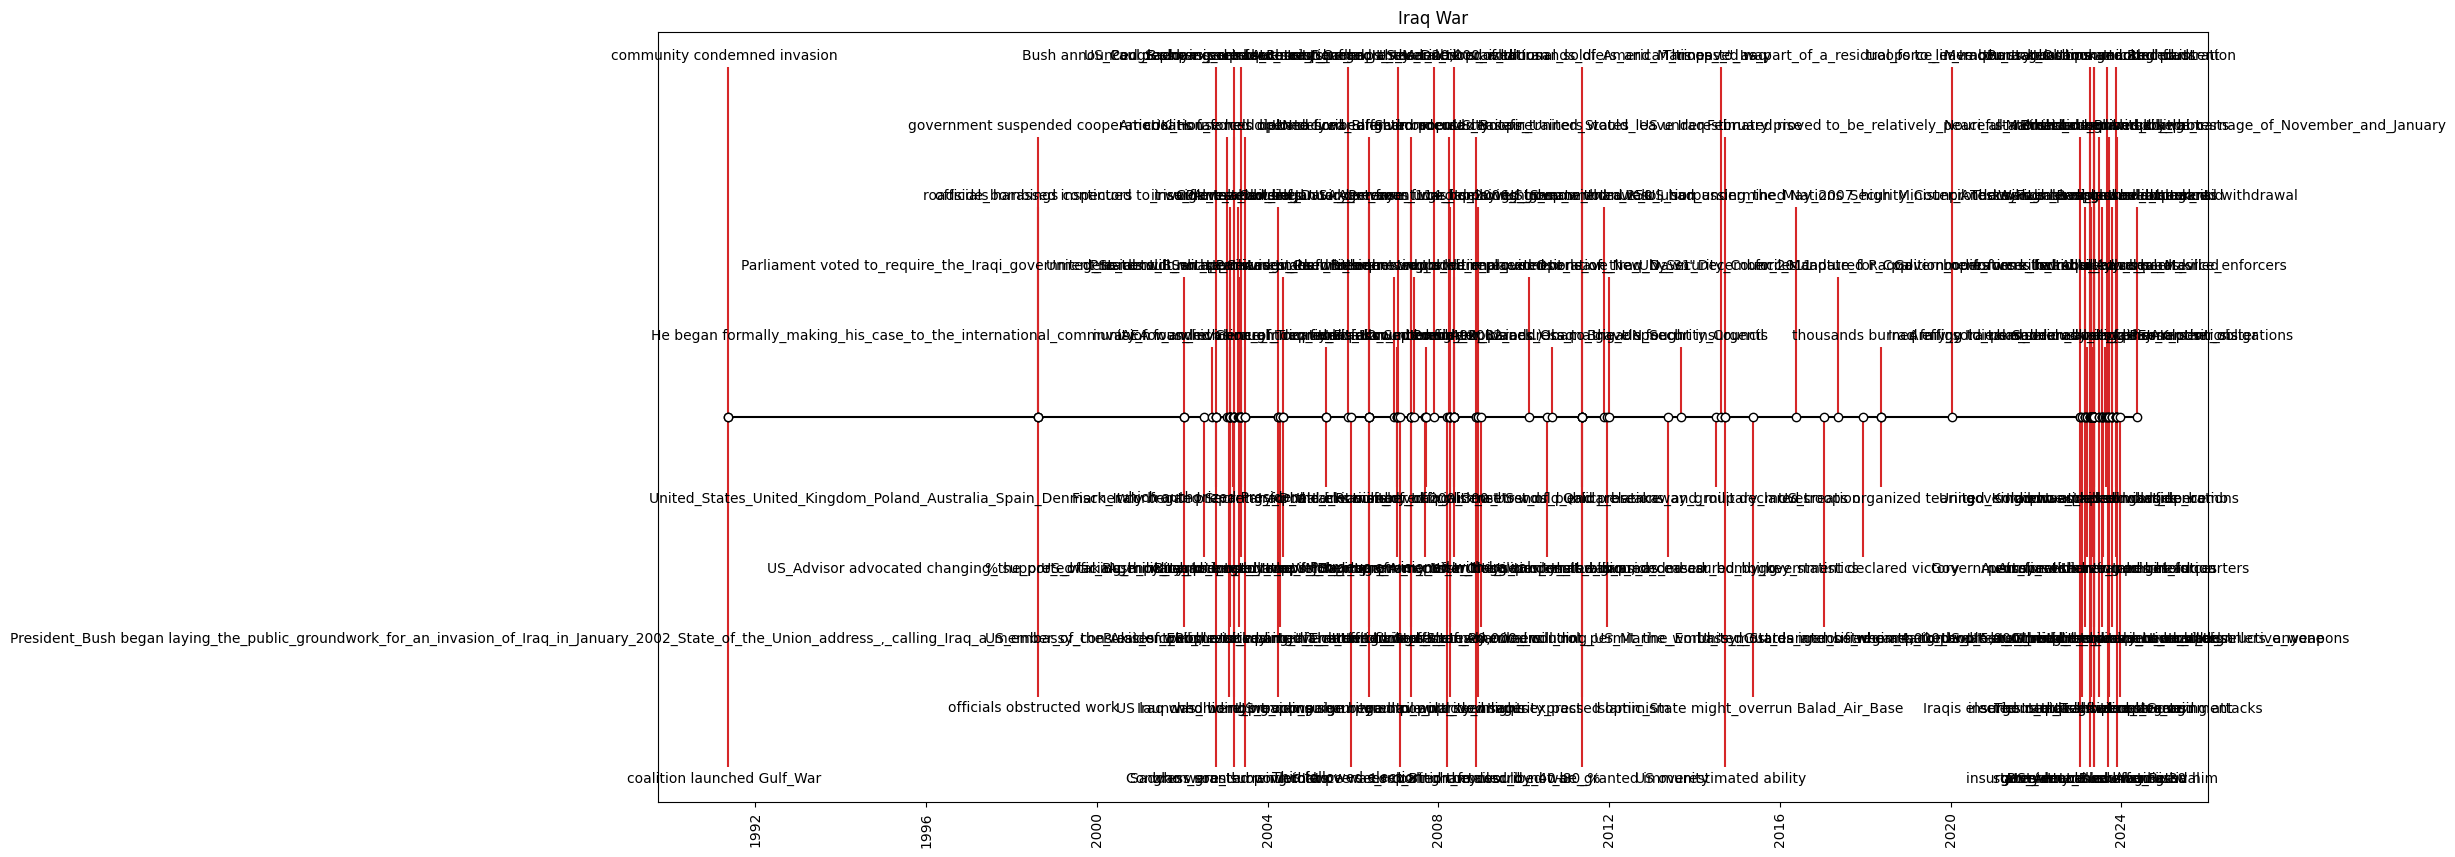

In [ ]:
dates = iraq_dtf_att["dt"].values
names = iraq_dtf_att["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title="Iraq War", yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), 
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90) 
plt.show()

Filter to specific time period

In [ ]:
import datetime

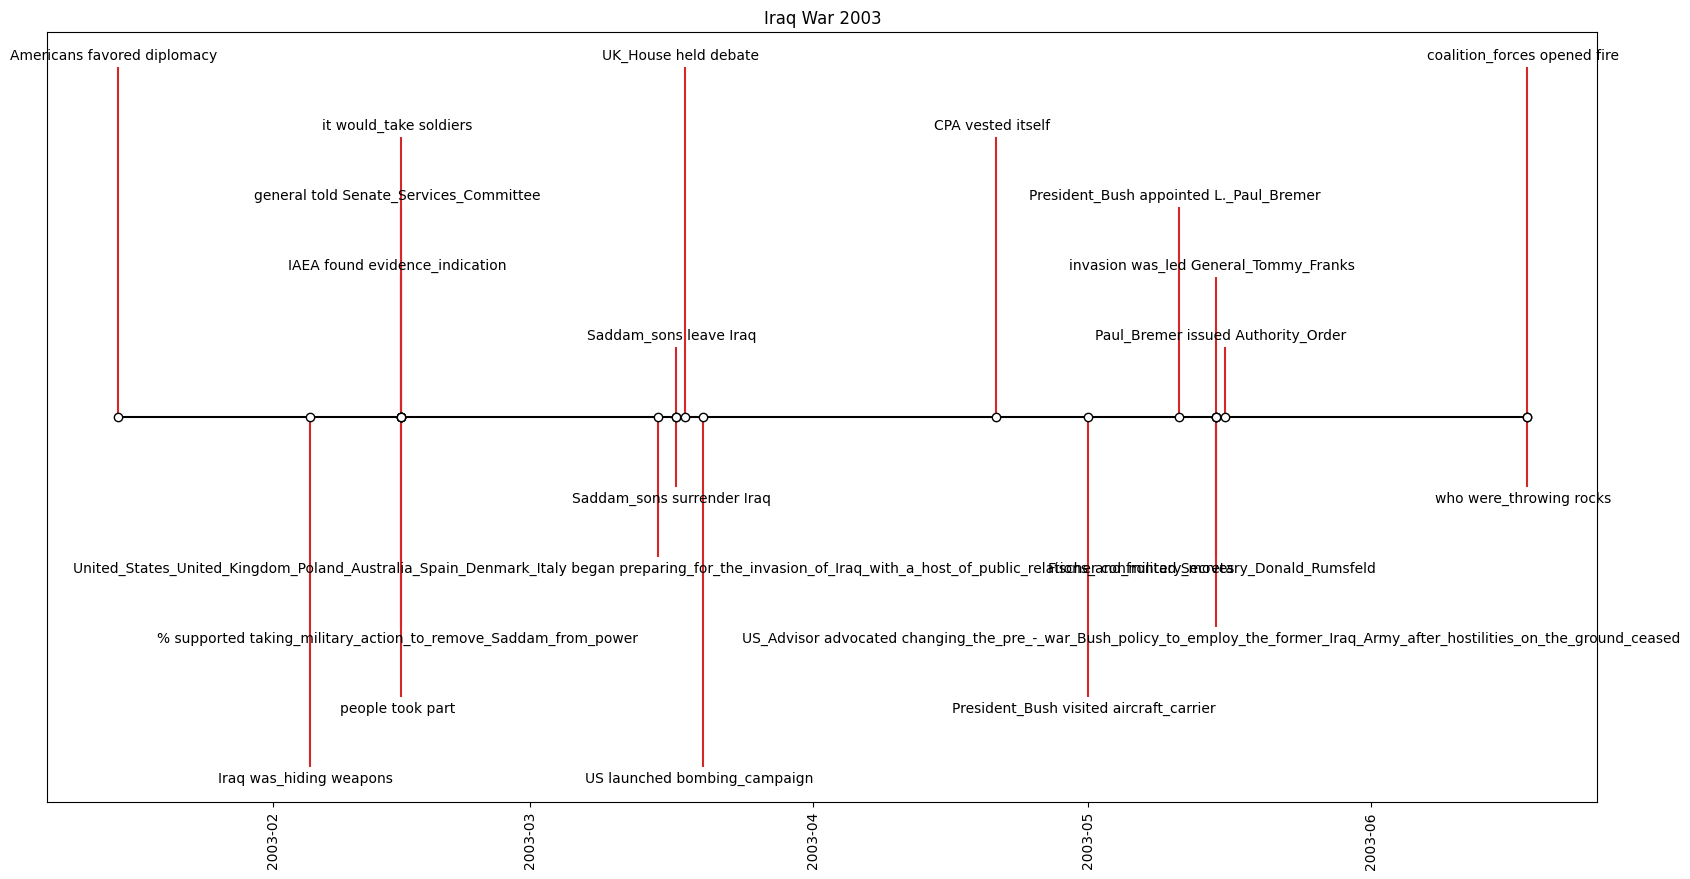

In [ ]:
# Change the two variables yyyy and yyyy1 to your desired period
yyyy = datetime.datetime(2002, 12, 30)
yyyy1 = datetime.datetime(2003, 12, 30)


dates = iraq_dtf_att[(iraq_dtf_att["dt"]>yyyy) & (iraq_dtf_att["dt"]<yyyy1)]["dt"].values
names = iraq_dtf_att[(iraq_dtf_att["dt"]>yyyy) & (iraq_dtf_att["dt"]<yyyy1)]["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title="Iraq War 2003", yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), 
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90) 
plt.show()

# Optional: NER Pipeline Training
Using specialised datasets to train the model's Named Entity Recognition pipeline, to obtain better NER accuracy for specific topics.

Dataset used in example: https://www.kaggle.com/datasets/finalepoch/medical-ner

Download and extract the archive.zip file to your computer, change the Corona2.json file's name to data.json, and upload it to your Colab session using the below code

In [29]:
from google.colab import files
files.upload()

Saving data.json to data.json


{'data.json': b'{"examples":[{"id":"18c2f619-f102-452f-ab81-d26f7e283ffe","content":"While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers\' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\\n\\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\\n\\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]","metadata":{},"anno

In [30]:
!apt install locales-all
!export LANG="en_US.UTF-8"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  locales-all
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.5 MB of archives.
After this operation, 227 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 locales-all amd64 2.31-0ubuntu9.9 [10.5 MB]
Fetched 10.5 MB in 0s (47.7 MB/s)
Selecting previously unselected package locales-all.
(Reading database ... 122675 files and directories currently installed.)
Preparing to unpack .../locales-all_2.31-0ubuntu9.9_amd64.deb ...
Unpacking locales-all (2.31-0ubuntu9.9) ...
Setting up locales-all (2.31-0ubuntu9.9) ...


Load the raw dataset

In [31]:
import json
 
with open('data.json', 'r', encoding="utf-8") as f:
    data = json.load(f)
    
print(data['examples'][0])

{'id': '18c2f619-f102-452f-ab81-d26f7e283ffe', 'content': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]", 'metadata': {}, 'annotations': [{'id': '0825a1bf-

Create training data object for SpaCy model

In [32]:
training_data = {'classes' : ['MEDICINE', "MEDICALCONDITION", "PATHOGEN"], 'annotations' : []}
for example in data['examples']:
  temp_dict = {}
  temp_dict['text'] = example['content']
  temp_dict['entities'] = []
  for annotation in example['annotations']:
    start = annotation['start']
    end = annotation['end']
    label = annotation['tag_name'].upper()
    temp_dict['entities'].append((start, end, label))
  training_data['annotations'].append(temp_dict)
  
print(training_data['annotations'][0])

{'text': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]", 'entities': [(360, 371, 'MEDICINE'), (383, 408, 'MEDICINE'), (104, 112, 'MEDICALCONDITION'), (679,

In [33]:
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object

In [34]:
from spacy.util import filter_spans

for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("training_data.spacy") # save the docbin object

100%|██████████| 31/31 [00:00<00:00, 388.13it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity
Skipping entity


In [ ]:
#!python -m spacy init fill-config base_config.cfg config.cfg

2023-05-14 19:41:35.832735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Create training config file for the model

In [35]:
from pathlib import Path

def create_config(model_name: str, component_to_update: str, output_path: Path):
    nlp = spacy.load(model_name)

    # create a new config as a copy of the loaded pipeline's config
    config = nlp.config.copy()

    # revert most training settings to the current defaults
    default_config = spacy.blank(nlp.lang).config
    config["corpora"] = default_config["corpora"]
    config["training"]["logger"] = default_config["training"]["logger"]

    # copy tokenizer and vocab settings from the base model, which includes
    # lookups (lexeme_norm) and vectors, so they don't need to be copied or
    # initialized separately
    config["initialize"]["before_init"] = {
        "@callbacks": "spacy.copy_from_base_model.v1",
        "tokenizer": model_name,
        "vocab": model_name,
    }
    config["initialize"]["lookups"] = None
    config["initialize"]["vectors"] = None

    config["training"]["max_steps"] = 1000
    config["training"]["eval_frequency"] = 200
    config["training"]["optimizer"]["learn_rate"]["total_steps"] = 1000

    # source all components from the loaded pipeline and freeze all except the
    # component to update; replace the listener for the component that is
    # being updated so that it can be updated independently
    config["training"]["frozen_components"] = []
    for pipe_name in nlp.component_names:
        if pipe_name != component_to_update:
            config["components"][pipe_name] = {"source": model_name}
            config["training"]["frozen_components"].append(pipe_name)
        else:
            config["components"][pipe_name] = {
                "source": model_name,
                "replace_listeners": ["model.tok2vec"],
            }

    # save the config
    config.to_disk(output_path)

In [36]:
create_config("en_core_web_trf", "ner", "/content/config.cfg")

Train the model

Important: to run the code, you need to connect to a Colab session with GPU (Runtime -> Change runtime type -> Choose GPU as hardware accelerator)

Some key parameters (full details available in the config.cfg file (click on the Files button on the left side)): 


```
[training]
dropout = 0.1
accumulate_gradient = 3
patience = 5000
max_epochs = 0
max_steps = 1000
eval_frequency = 200
frozen_components = ["transformer","tagger","parser","attribute_ruler","lemmatizer"]

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
get_length = null
size = 2000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"
beta1 = 0.9
beta2 = 0.999
L2_is_weight_decay = true
L2 = 0.01
grad_clip = 1.0
use_averages = true
eps = 0.00000001

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 1000
initial_rate = 0.00005
```



In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy --gpu-id 0

2023-05-14 20:12:26.471863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-05-14 20:12:37,429] [INFO] Set up nlp object from config
[2023-05-14 20:12:37,449] [INFO] Pipeline: ['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
[2023-05-14 20:12:37,449] [INFO] Resuming training for: ['ner']
[2023-05-14 20:12:37,577] [INFO] Copying tokenizer from: en_core_web_trf
[2023-05-14 20:12:41,788] [INFO] Copying vocab from: en_core_web_trf
[2023-05-14 20:12:41,933] [INFO] Created vocabulary
[2023-05-14 20:12:41,935] [INFO] Finished initializing nlp object
[2023-05-14 20:12:41,936] [INFO] Initialized pipeline components: []
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'tagger', 'parser', 'attribute_ruler',
'lemma

Example of NER

In [38]:
page_medical = wiki.page("HIV/AIDS")
txt_medical = page_medical.text[:page_medical.text.find("See also")]
txt_medical[0:500] + " ..."

'Human immunodeficiency virus infection and acquired immunodeficiency syndrome (HIV/AIDS) is a spectrum of conditions caused by infection with the human immunodeficiency virus (HIV), a retrovirus. Following initial infection an individual may not notice any symptoms, or may experience a brief period of influenza-like illness. Typically, this is followed by a prolonged incubation period with no symptoms. If the infection progresses, it interferes more with the immune system, increasing the risk of ...'

In [39]:
nlp_ner = spacy.load("model-best")
nlp_pretrained = spacy.load("en_core_web_trf")

Compare our new model with trained NER to SpaCy's pretrained model (first paragraph is the new model's results, second paragraph is the pretrained model's.)

In [ ]:
doc = nlp_ner(txt_medical[0:1500])
doc1 = nlp_pretrained(txt_medical[0:1500])

colors = {"PATHOGEN": "#F67DE3", "MEDICINE": "#7DF6D9", "MEDICALCONDITION":"#FFFFFF"}
options = {"colors": colors} 

spacy.displacy.render(doc, style="ent", options= options, jupyter=True)
print()
print()
spacy.displacy.render(doc1, style="ent", options= options, jupyter=True)